# Question 3 assessment

### Imports & data loading


In [78]:
#importing libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In order to prove feasiblity, ratings_with_text_rb.txt file in the matched_beer_data is evaluated. This file is not in encoded in conventional excel format(s) which means that further processing is required to acheive the desired dataframe. 

In [3]:
# read the ratings_with_text_rb.txt file in key:value format 
data_file = "C:\\Users\\Parsa\\Downloads\\matched_beer_data.tar\\matched_beer_data\\ratings_with_text_rb.txt.gz"
read_data = pd.read_csv(data_file, sep=":", header=None, names=["Key", "Value"], on_bad_lines='skip')

In [4]:
selected_col = read_data['Key'].unique()
df = pd.DataFrame(columns=selected_col)

# Create a dictionary to hold the series for each unique key
series_dict = {col: pd.Series(dtype=object) for col in selected_col}

# Populate the dictionary with values for each unique key
for col in selected_col:
    mask = read_data['Key'] == col
    series_dict[col] = read_data[mask]['Value'].reset_index(drop=True)

# create new DataFrame from the dictionary
df = pd.DataFrame(series_dict)

In [6]:
df.head(10)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1429178400,ciaranc,151109,3,7,2,8,17,3.70,"Bottle, gift from Aaron. Black, big head, lot..."
1,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1427796000,Rowlymo,198957,4,7,4,8,15,3.80,500ml Bottle in Bittles bar Belfast. Chocolat...
2,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1421665200,Don2711,285162,4,8,5,7,17,4.10,Great one and made very local to me. Bottle b...
3,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1380621600,genegenie,224156,5,8,3,5,19,4.00,"Deep roasted aroma, good dark brown/black col..."
4,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1371549600,kiwianer,88501,4,7,4,7,14,3.60,"The head is medium, the body black. It smells..."
5,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1321527600,Beersiveknown,128086,5,7,5,7,16,4.00,Cask@ Belfast beer fest. Dark brown black wit...
6,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1382436000,Beersiveknown,128086,4,7,4,5,13,3.30,"Bottle at Bittles Bar, BelfastHazy amber brow..."
7,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1371549600,kiwianer,88501,4,7,3,5,14,3.30,"The head is stable, the body golden, orange. ..."
8,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1385550000,genegenie,224156,5,8,4,9,18,4.40,Hard to find but worth it when you do. A refr...
9,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1339581600,visionthing,91324,4,7,4,7,14,3.60,"50cl bottle (4,8% ABV) at Bittles Bar, Belfas..."


To start, the users with highest number of ratings are found and their rating score distributions are plotted in the form of box plots.

In [7]:
# the useful columns are kept and users with highest ranking are displayed
reviewer_rating = df[['user_name', 'rating']].copy()
reviewer_rating['rating'] = pd.to_numeric(reviewer_rating['rating'])
num_reviews = reviewer_rating.groupby(['user_name']).size().reset_index(name='count').sort_values('count', ascending =False)
num_reviews.head(10)

,user_name,count
27486,yespr,5209
17337,fonefan,5160
11922,Ungstrup,4149
11750,Travlr,3819
13082,anders37,3732
19539,joergen,3241
21118,madmitch76,3229
22878,oh6gdx,3051
22953,omhper,2954
15103,cgarvieuk,2856


In [8]:
# filter reviewers with less than 50 reviews  
num_reviews_filter = num_reviews[num_reviews['count'] > 50]
print("Initial size: " + str(len(num_reviews)))
print("Size after filtering: " + str(len(num_reviews_filter)))

Initial size: 27674
Size after filtering: 3099


In [9]:
#take the first N reviewers and plot the score distribution in box plot 
N = 10
top_reviewers = num_reviews_filter.head(N).user_name
df_top_reviewers = df.merge(right=top_reviewers, on=['user_name'], how='right')[['user_name', 'rating']]
df_top_reviewers['rating'] = pd.to_numeric(df_top_reviewers['rating']) 

In [10]:
# check for NaNs 
print("Number of NaNs in ratings: " + str(df_top_reviewers.rating.isna().sum()))

Number of NaNs in ratings: 0


Text(0.5, 1.0, '')

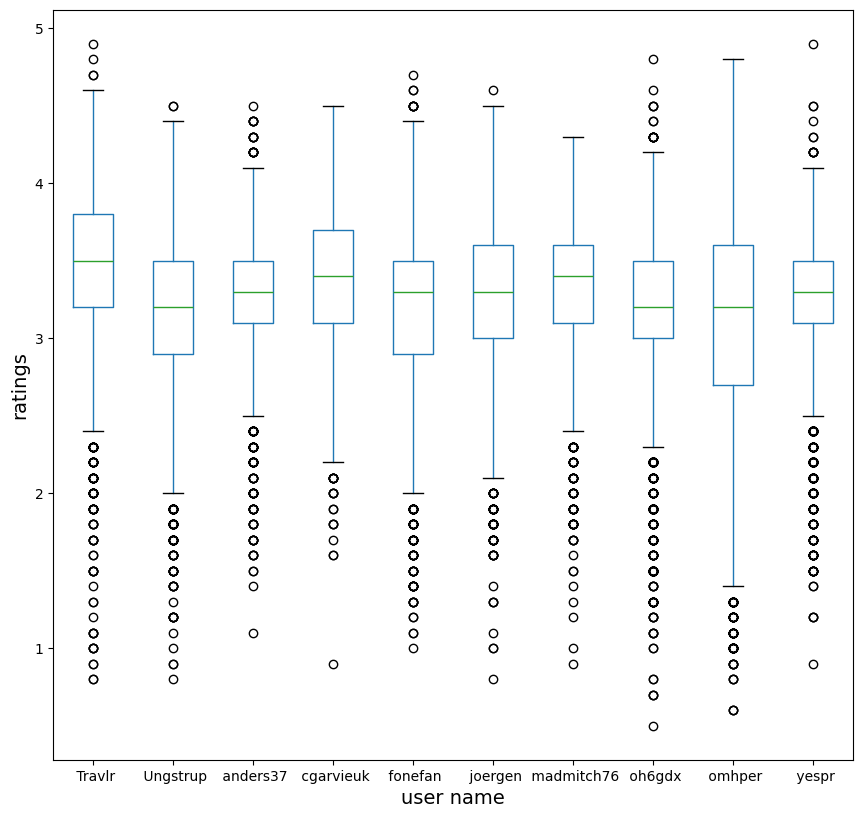

In [11]:
#Box plots displaying the distribution of scores of reviewers 
bp = df_top_reviewers.boxplot(by='user_name', figsize=(10,10), grid=False, fontsize = 10)
bp.get_figure().suptitle('')
bp.set_ylabel('ratings', fontsize = 14)
bp.set_xlabel('user name', fontsize = 14)
bp.set_title('')


The "Nice Users" are selected by first looking at their percentage of ratings below a certain threshold (3 out of 5). If the ratio of number of low ratings against the total number of ratings is lower than the percentage thresold ( less or equal than 15%), the Augmented Dickey-Fuller (ADF) test is done to determine whether their ratings time series can be identified as stationary. If all the conditions mentioned above are satisfied the user is enlisted as a "Nice User".

In [79]:
# looking for users that consistently rate above threshold 

# parameters 
threshold = 3
percentage_threshold = 0.15
alpha = 0.05 
nice_users = []

# Take data of users with more than 50 ratings 
high_raters = pd.merge(reviewer_rating, num_reviews_filter, on='user_name')
# TEST :  set(reviewer_rating['user_name']) == set(high_raters['user_name'])
review_low_ratings = high_raters[high_raters['rating'] < threshold].groupby('user_name').size().reset_index(name='low_count')

In [80]:
for member in review_low_ratings['user_name']:
    low_count = review_low_ratings[review_low_ratings['user_name'] == member].low_count.values[0]
    count = num_reviews_filter[num_reviews_filter['user_name'] == member].values[0][1]
    # percentage of low rating count to total rating count 
    low_percentage = low_count/count 
    
    if ( low_percentage <= percentage_threshold ):
        array_rating = high_raters[high_raters['user_name'] == member]['rating'].to_numpy()
        
        # ADF Score to find if the series is stationnary 
        p_value = adfuller(array_rating)[1]

        # null hyp: series is not stationnary which is violated if p_value <= alpha 
        if ( p_value <= alpha ):
            nice_users.append(member)


In [81]:
print("Number of detected Nice Users : "  + str(len(nice_users)))

Number of detected Nice Users : 1419


In the section below, the entimental information is extracted from the reviewer's text in a scale which would be comparable to the user ratings of the beers. As a proof of conecpt, the reviews of only one user is chosen to be anaylzed, since the method is extendable to the whole dataset. For this purpose BERT Mutilingual Sentimental Analysis pretrained model is used. This model is trained on wikipedia pages of 104 languages. The reason of this choice is to cover as many languages possible. For more information on BERT: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment. By pure coincidence, the sentimental scale used by this classifier (0-5) is the same scale as the beer ratings, with the difference of being categorical. 

In [21]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from transformers import pipeline, TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Parsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
# extract texts and ratings of useres with more than 50 reviews
#sample data for M users only 
red  = 5
nice_users_red = nice_users[:red]

text_from_reviewer = df[df['user_name'].isin(nice_users_red)][['user_name', 'rating', 'text']]
# drop the reviews without textual information
text_from_reviewer = text_from_reviewer[text_from_reviewer['text'].notna()]
top_user_names = text_from_reviewer['user_name'].unique()

print("Number of samples : " + str(len(text_from_reviewer)))
text_from_reviewer.head(10)

Number of samples : 1462


,user_name,rating,text
265,47574xeCD,3.50,"Bottle at bittlesCoffee, fruity dank hops, pi..."
4205,5000,3.20,Bouteille de 500 ml. ArÃ´mes surtout dominÃ©s...
6087,11026,3.00,"I donât know that this is a dunkel, Bushwak..."
6159,5000,3.30,On tap at Bushwakkers in Regina. Likely my f...
6164,1FastSTi,3.00,Drank at Bushwakkerâs in Regina. Appearanc...
6305,5000,3.50,"Wow, a fantastic porter. Lots of coffee in th..."
6313,1FastSTi,3.90,"Bottle, via trade from paco, shared with Park..."
12974,5000,3.60,"Brown , black tea like , small head . Medium ..."
19209,5000,3.50,Clear copper poor with a healthy foamy beige ...
34715,1FastSTi,1.60,Pours a clear pale straw color with a big whi...


In [58]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', ' '.join(tokens))  
    return clean_text

In [59]:
# Load pre-trained model and tokenizer for multilingual sentiment analysis &  
# Create sentiment analysis pipeline
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True)
sentiment_analysis = pipeline("sentiment-analysis", truncation=True, model=model, tokenizer=tokenizer)

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [69]:
#remove stop words as well as invalid characters
cleaned_text_array = np.vectorize(preprocess_text)(text_from_reviewer['text'])

In [70]:
#Sentiment prediction 
results = np.vectorize(sentiment_analysis)(cleaned_text_array)

In [71]:
print(results[0])

[{'label': '5 stars', 'score': 0.7099984288215637}]


In [72]:
sentiment_score = np.zeros((len(results), 2), dtype=float)

for i,r in enumerate(results):
    sentiment_score[i,0] = int(r[0]['label'].split()[0]) #extract the integer score
    sentiment_score[i,1] = r[0]['score']
        

1000


For a visual check of the difference between the Sentimental rating and the actual rating of the users, their distributions are plotted as Violon plots.

In [140]:
# Violon plots to compare the difference of distributions of text predicted scores 
# and ratings of one reviewer

aug_reviewer_info = text_from_reviewer.copy()
aug_reviewer_info['pred_score'] = sentiment_score[:,0]
aug_reviewer_info['pred_accu.'] = sentiment_score[:,1]


# remove samples with an accuracy less than threshold_accu
threshold_accu = 0.40 
aug_reviewer_info = aug_reviewer_info[aug_reviewer_info['pred_accu.'] >= threshold_accu]

aug_reviewer_info.head()

,user_name,rating,text,pred_score,pred_accu.
265,47574xeCD,3.50,"Bottle at bittlesCoffee, fruity dank hops, pi...",5.0,0.709998
4205,5000,3.20,Bouteille de 500 ml. ArÃ´mes surtout dominÃ©s...,3.0,0.451697
6305,5000,3.50,"Wow, a fantastic porter. Lots of coffee in th...",5.0,0.789971
6313,1FastSTi,3.90,"Bottle, via trade from paco, shared with Park...",5.0,0.473637
12974,5000,3.60,"Brown , black tea like , small head . Medium ...",4.0,0.462877


C:\Users\Parsa\AppData\Local\Temp\ipykernel_24456\1070747570.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\Parsa\AppData\Local\Temp\ipykernel_24456\1070747570.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


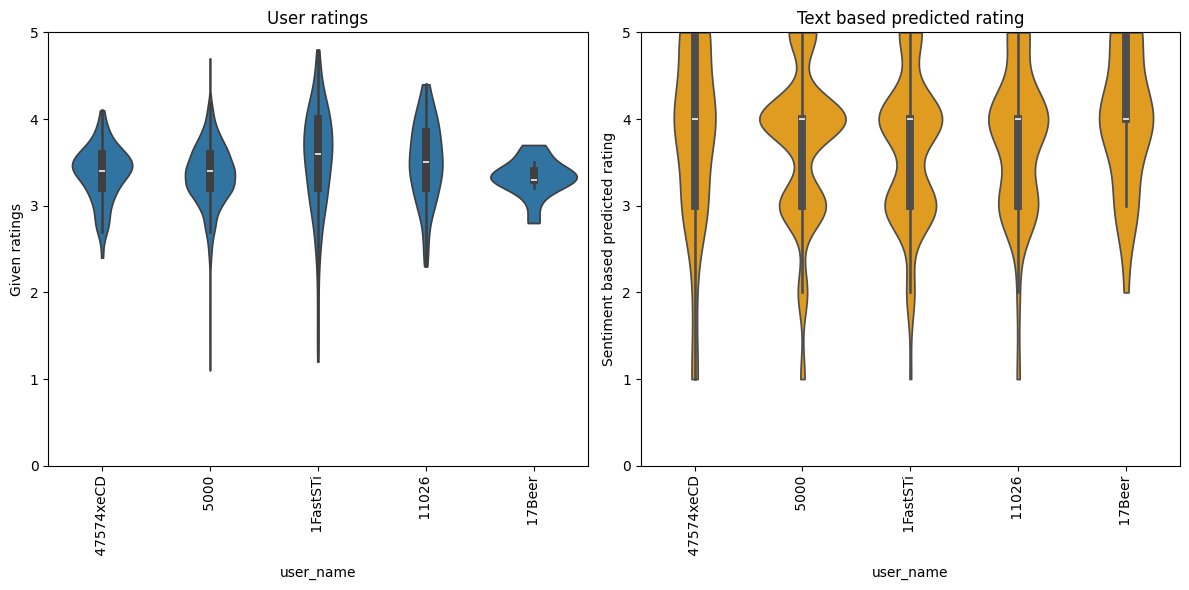

In [141]:
aug_reviewer_info = aug_reviewer_info.explode('rating')
aug_reviewer_info['rating'] = aug_reviewer_info['rating'].astype('float')

aug_reviewer_info = aug_reviewer_info.explode('pred_score')
aug_reviewer_info['pred_score'] = aug_reviewer_info['pred_score'].astype('float')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(data=aug_reviewer_info, x="user_name", y='rating', ax=axes[0], cut=0)
axes[0].set_title('User ratings')
axes[0].set_ylabel('Given ratings')
axes[0].set_ylim([0, 5])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  

sns.violinplot(data=aug_reviewer_info, x="user_name", y='pred_score', ax=axes[1], cut=0, color = "orange")
axes[1].set_title('Text based predicted rating')
axes[1].set_ylabel('Sentiment based predicted rating')
axes[1].set_ylim([0, 5])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  

plt.tight_layout()
plt.show()

In [ ]:
# extract texts and ratings of useres with more than 50 reviews
# for the whole data set

text_from_reviewer = df[df['user_name'].isin(nice_users_red)][['user_name', 'rating', 'text']]
# drop the reviews without textual information
text_from_reviewer = text_from_reviewer[text_from_reviewer['text'].notna()]
top_user_names = text_from_reviewer['user_name'].unique()

print("Number of samples : " + str(len(text_from_reviewer)))

#remove stop words as well as invalid characters
cleaned_text_total = np.vectorize(preprocess_text)(text_from_reviewer['text'])

#Sentiment prediction 
results_total = np.vectorize(sentiment_analysis)(cleaned_text_total)

sentiment_score_total = np.zeros((len(results), 2), dtype=float)

for i,r in enumerate(results_total):
    sentiment_score_total[i,0] = int(r[0]['label'].split()[0]) #extract the integer score
    sentiment_score_total[i,1] = r[0]['score']

# Store results in a copy of the original dataframe
aug_reviewer_info = text_from_reviewer.copy()
aug_reviewer_info['pred_score'] = sentiment_score[:,0]
aug_reviewer_info['pred_accu.'] = sentiment_score[:,1] 

# remove samples with an accuracy less than threshold_accu
threshold_accu = 0.40 
aug_reviewer_info = aug_reviewer_info[aug_reviewer_info['pred_accu.'] >= threshold_accu]

A balancing metric is required to even out the inherent biases of the reviewers between putting down an actual score or writing their opininon in text. As displayed above this bias becomes apparent whilst comparing the ratings of a given reviewer with the perceived sentiment from their written review text. The *interpolated rating (ir)* can be expressed with the balancing formula as:

$$  ir_i = {rating_i*(1-\alpha) + sentiment\_rating_i*\alpha } $$

Where for a given user *ratings* represent the given score by the reviewer, *sentiment_rating* the sentimenal analysis score, *i* the index, and $\alpha\in[0,1]$ a balancing coefficient which has to be defined as below: 
    
- if the distributions of *ratings* & *sentiment_rating* are **close enough** $\alpha = 0.5$ 
- if the reviewer tends to **overrate** according to the *ratings* & *sentiment_rating* distribution differences  $  \alpha > 0.5$ 
- if the reviewer tends to **underrate** according to the *ratings* & *sentiment_rating* distribution differences  $  \alpha < 0.5$

In [142]:
aug_reviewer_info["ir"] = 0.5
for member in nice_users_red: 
    user_info = aug_reviewer_info[aug_reviewer_info['user_name'] == member][['rating', 'pred_score', 'pred_accu.', 'ir']]
    alpha = 0.5 - (user_info['rating'].mean() -  user_info['pred_score'].mean()) 
    ir = (user_info['rating']*(1-alpha) + user_info['pred_score']*alpha)
    aug_reviewer_info.loc[aug_reviewer_info['user_name'] == member, 'ir'] = ir


In [143]:
aug_reviewer_info.head(10)

,user_name,rating,text,pred_score,pred_accu.,ir
265,47574xeCD,3.5,"Bottle at bittlesCoffee, fruity dank hops, pi...",5.0,0.709998,4.862651
4205,5000,3.2,Bouteille de 500 ml. ArÃ´mes surtout dominÃ©s...,3.0,0.451697,3.029481
6305,5000,3.5,"Wow, a fantastic porter. Lots of coffee in th...",5.0,0.789971,4.778889
6313,1FastSTi,3.9,"Bottle, via trade from paco, shared with Park...",5.0,0.473637,4.603880
12974,5000,3.6,"Brown , black tea like , small head . Medium ...",4.0,0.462877,3.941037
19209,5000,3.5,Clear copper poor with a healthy foamy beige ...,2.0,0.468794,2.221111
34715,1FastSTi,1.6,Pours a clear pale straw color with a big whi...,5.0,0.836453,3.775628
35618,5000,3.4,Really enjoyed this very smooth extremely dar...,5.0,0.498634,4.764148
35794,5000,3.3,Real nice roasts nutty nose with a good dose ...,5.0,0.600097,4.749407
43965,5000,2.4,Bottle from LCBO at the Farm. Black slightly ...,3.0,0.449091,2.911556
